# Week 6: K-Nearest Neighbors and Distance Metrics - Comprehensive Guide

## Introduction: The Power of Similarity

Welcome to our deep dive into K-Nearest Neighbors (KNN), one of the most intuitive yet powerful algorithms in machine learning. Unlike the algorithms we've studied so far that build explicit models during training (like logistic regression's weights or linear regression's coefficients), KNN takes a fundamentally different approach: it makes predictions based on the principle that similar things exist in close proximity.

### Why KNN Matters in Data Science

Imagine you're trying to predict whether a customer will purchase a product. Traditional approaches might build a complex model with numerous parameters. KNN simply asks: "Who are the most similar customers we've seen before, and what did they do?" This elegantly simple approach has profound implications:

1. **No Training Phase**: KNN is a "lazy learner" - it doesn't build an explicit model during training. Instead, it stores all the data and does the work during prediction time.

2. **Non-parametric Nature**: KNN makes no assumptions about the underlying data distribution. This makes it incredibly flexible and capable of capturing complex, non-linear patterns that would be difficult for linear models.

3. **Local Decision Making**: While models like logistic regression make global decisions (one decision boundary for all data), KNN makes local decisions based on the immediate neighborhood of each point.

### Real-World Applications

Before we dive into the technical details, let's understand where KNN shines in practice:

- **Recommendation Systems**: Netflix and Amazon use variations of KNN to find similar users or products
- **Image Recognition**: Finding similar images in large databases
- **Anomaly Detection**: Identifying fraudulent transactions by their distance from normal behavior
- **Missing Data Imputation**: Filling in missing values based on similar complete records
- **Gene Expression Analysis**: Classifying genes based on expression patterns

### What We'll Cover

In this comprehensive notebook, we'll explore:
1. The mathematical foundations of distance metrics
2. How KNN makes predictions for both classification and regression
3. The critical importance of feature scaling
4. Advanced evaluation techniques for classification
5. Practical implementation considerations and optimizations
6. Hands-on exercises to solidify your understanding

Let's begin our journey into the world of instance-based learning!

In [14]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report,
    roc_curve, auc, precision_recall_curve, average_precision_score
)
from sklearn.datasets import make_classification, make_moons, make_circles, load_iris
import sklearn

import warnings
warnings.filterwarnings('ignore')

# Set style for better-looking plots
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Set random seed for reproducibility
np.random.seed(42)

print("Libraries loaded successfully!")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")
print(f"Scikit-learn version: {sklearn.__version__}")

Libraries loaded successfully!
NumPy version: 2.0.1
Pandas version: 2.2.3
Scikit-learn version: 1.6.1


## Part 1: Understanding Distance Metrics

### The Foundation of KNN: What is Distance?

At its core, KNN relies on a simple concept: measuring how "far apart" two data points are. But this seemingly simple idea opens up a world of complexity. In machine learning, distance is not just about physical space - it's about similarity in feature space.

Think of it this way: if we're comparing customers, the "distance" between two customers might involve their age, income, purchase history, and browsing behavior. Each of these features contributes to an overall measure of how similar or different these customers are.

### Mathematical Foundations

Let's explore the most common distance metrics and understand when to use each one.

In [15]:
# Let's implement and visualize different distance metrics

class DistanceMetrics:
    """A class to demonstrate various distance metrics"""
    
    @staticmethod
    def euclidean_distance(p1, p2):
        """Calculate Euclidean distance between two points"""
        return np.sqrt(np.sum((p1 - p2) ** 2))
    
    @staticmethod
    def manhattan_distance(p1, p2):
        """Calculate Manhattan (L1) distance between two points"""
        return np.sum(np.abs(p1 - p2))
    
    @staticmethod
    def minkowski_distance(p1, p2, p_value):
        """Calculate Minkowski distance (generalization of Euclidean and Manhattan)"""
        return np.sum(np.abs(p1 - p2) ** p_value) ** (1/p_value)
    
    @staticmethod
    def cosine_similarity(p1, p2):
        """Calculate cosine similarity between two points"""
        dot_product = np.dot(p1, p2)
        norm_p1 = np.linalg.norm(p1)
        norm_p2 = np.linalg.norm(p2)
        return dot_product / (norm_p1 * norm_p2)
    
    @staticmethod
    def cosine_distance(p1, p2):
        """Calculate cosine distance (1 - cosine similarity)"""
        return 1 - DistanceMetrics.cosine_similarity(p1, p2)

# Demonstrate with examples
point_a = np.array([1, 2, 3])
point_b = np.array([4, 5, 6])

dm = DistanceMetrics()

print("Distance Metrics Comparison")
print("=" * 40)
print(f"Point A: {point_a}")
print(f"Point B: {point_b}")
print("-" * 40)
print(f"Euclidean Distance:   {dm.euclidean_distance(point_a, point_b):.4f}")
print(f"Manhattan Distance:   {dm.manhattan_distance(point_a, point_b):.4f}")
print(f"Minkowski (p=3):      {dm.minkowski_distance(point_a, point_b, 3):.4f}")
print(f"Cosine Similarity:    {dm.cosine_similarity(point_a, point_b):.4f}")
print(f"Cosine Distance:      {dm.cosine_distance(point_a, point_b):.4f}")

Distance Metrics Comparison
Point A: [1 2 3]
Point B: [4 5 6]
----------------------------------------
Euclidean Distance:   5.1962
Manhattan Distance:   9.0000
Minkowski (p=3):      4.3267
Cosine Similarity:    0.9746
Cosine Distance:      0.0254


### Visualizing Distance Metrics

To truly understand how different distance metrics work, let's visualize them in 2D space. This will help us see how the choice of metric affects which points are considered "nearest" neighbors.

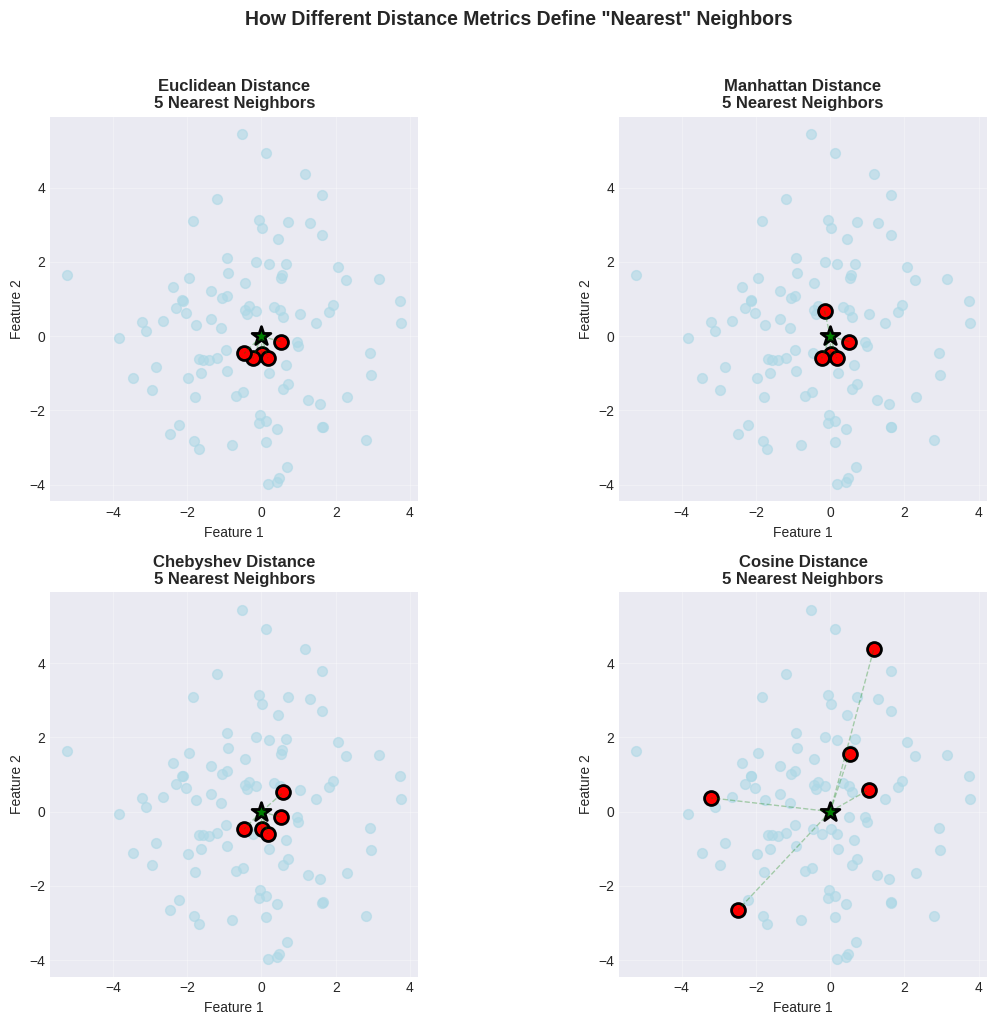

In [16]:
# Create a visualization showing how different metrics define "nearness"
def visualize_distance_metrics():
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    # Generate sample data
    np.random.seed(42)
    n_points = 100
    X = np.random.randn(n_points, 2) * 2
    
    # Query point (center)
    query = np.array([0, 0])
    
    # Calculate distances using different metrics
    from scipy.spatial import distance
    
    metrics = [
        ('Euclidean', 'euclidean'),
        ('Manhattan', 'cityblock'),
        ('Chebyshev', 'chebyshev'),
        ('Cosine', 'cosine')
    ]
    
    for ax, (name, metric) in zip(axes.flat, metrics):
        # Calculate distances
        distances = [distance.cdist([query], [point], metric=metric)[0, 0] for point in X]
        
        # Find k nearest neighbors
        k = 5
        nearest_indices = np.argsort(distances)[:k]
        
        # Plot all points
        ax.scatter(X[:, 0], X[:, 1], c='lightblue', alpha=0.6, s=50)
        
        # Highlight nearest neighbors
        ax.scatter(X[nearest_indices, 0], X[nearest_indices, 1], 
                  c='red', s=100, edgecolors='black', linewidth=2)
        
        # Plot query point
        ax.scatter(query[0], query[1], c='green', s=200, marker='*', 
                  edgecolors='black', linewidth=2)
        
        # Draw lines to nearest neighbors
        for idx in nearest_indices:
            ax.plot([query[0], X[idx, 0]], [query[1], X[idx, 1]], 
                   'g--', alpha=0.3, linewidth=1)
        
        ax.set_title(f'{name} Distance\n5 Nearest Neighbors', fontsize=12, fontweight='bold')
        ax.set_xlabel('Feature 1')
        ax.set_ylabel('Feature 2')
        ax.grid(True, alpha=0.3)
        ax.set_aspect('equal')
    
    plt.suptitle('How Different Distance Metrics Define "Nearest" Neighbors', 
                fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()

visualize_distance_metrics()

### Understanding When to Use Each Metric

The choice of distance metric can significantly impact KNN's performance. Here's a detailed guide:

#### 1. **Euclidean Distance** (L2 norm)
- **Use when**: Features represent continuous measurements in actual space
- **Examples**: Geographic coordinates, physical measurements, sensor readings
- **Characteristics**: Sensitive to scale, gives the shortest "straight-line" path
- **Formula**: $d(p, q) = \sqrt{\sum_{i=1}^{n} (p_i - q_i)^2}$

#### 2. **Manhattan Distance** (L1 norm, City Block)
- **Use when**: Movement is restricted to grid-like paths, or features are not directly comparable
- **Examples**: City navigation, difference in ratings, pixel differences in images
- **Characteristics**: Less sensitive to outliers than Euclidean, sums absolute differences
- **Formula**: $d(p, q) = \sum_{i=1}^{n} |p_i - q_i|$

#### 3. **Minkowski Distance**
- **Use when**: You want to experiment with different distance behaviors
- **Characteristics**: Generalizes both Euclidean (p=2) and Manhattan (p=1)
- **Formula**: $d(p, q) = (\sum_{i=1}^{n} |p_i - q_i|^p)^{1/p}$

#### 4. **Cosine Distance**
- **Use when**: Magnitude doesn't matter, only direction/orientation
- **Examples**: Text analysis, document similarity, user preferences
- **Characteristics**: Measures angle between vectors, invariant to scaling
- **Formula**: $d(p, q) = 1 - \frac{p \cdot q}{||p|| \cdot ||q||}$

Performance with Different Distance Metrics (Unscaled Data)
Euclidean       accuracy: 0.711
Manhattan       accuracy: 0.722
Chebyshev       accuracy: 0.711
Minkowski       accuracy: 0.711

Performance with Different Distance Metrics (Scaled Data)
Euclidean       accuracy: 0.956
Manhattan       accuracy: 0.944
Chebyshev       accuracy: 0.956
Minkowski       accuracy: 0.956


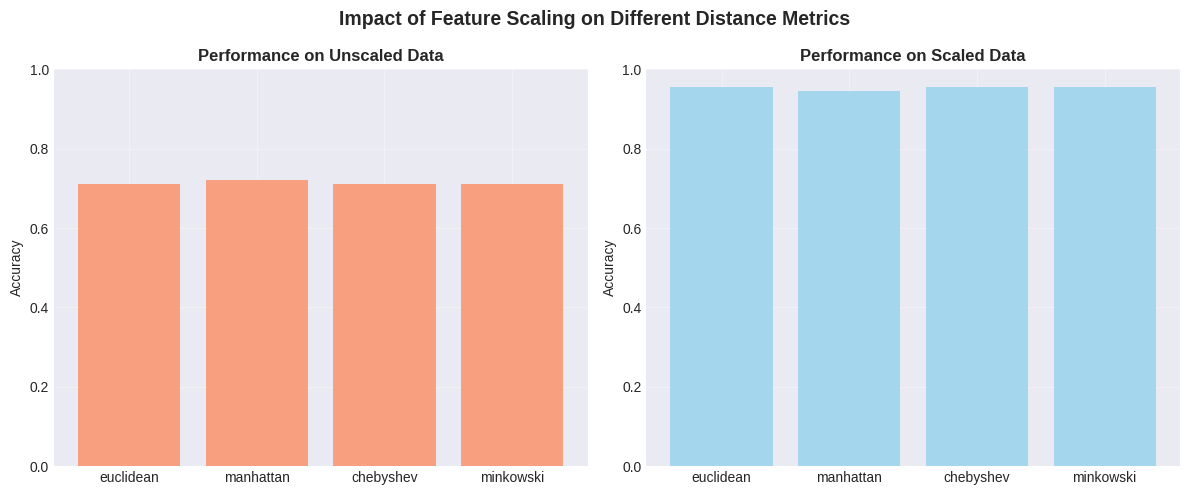

In [17]:
# Practical example: Impact of distance metrics on real data
def compare_metrics_on_data():
    # Create a dataset with different feature scales
    from sklearn.datasets import make_classification
    
    X, y = make_classification(n_samples=300, n_features=2, n_informative=2,
                              n_redundant=0, n_clusters_per_class=1,
                              random_state=42)
    
    # Artificially scale features differently
    X[:, 0] *= 100  # Scale first feature by 100
    X[:, 1] *= 0.1  # Scale second feature by 0.1
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    # Test different metrics
    metrics = ['euclidean', 'manhattan', 'chebyshev', 'minkowski']
    results = {}
    
    print("Performance with Different Distance Metrics (Unscaled Data)")
    print("=" * 60)
    
    for metric in metrics:
        knn = KNeighborsClassifier(n_neighbors=5, metric=metric)
        knn.fit(X_train, y_train)
        score = knn.score(X_test, y_test)
        results[metric] = score
        print(f"{metric.capitalize():15} accuracy: {score:.3f}")
    
    # Now with scaled data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    print("\nPerformance with Different Distance Metrics (Scaled Data)")
    print("=" * 60)
    
    results_scaled = {}
    for metric in metrics:
        knn = KNeighborsClassifier(n_neighbors=5, metric=metric)
        knn.fit(X_train_scaled, y_train)
        score = knn.score(X_test_scaled, y_test)
        results_scaled[metric] = score
        print(f"{metric.capitalize():15} accuracy: {score:.3f}")
    
    # Visualize the difference
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # Unscaled performance
    ax1.bar(results.keys(), results.values(), color='coral', alpha=0.7)
    ax1.set_title('Performance on Unscaled Data', fontweight='bold')
    ax1.set_ylabel('Accuracy')
    ax1.set_ylim([0, 1])
    ax1.grid(True, alpha=0.3)
    
    # Scaled performance
    ax2.bar(results_scaled.keys(), results_scaled.values(), color='skyblue', alpha=0.7)
    ax2.set_title('Performance on Scaled Data', fontweight='bold')
    ax2.set_ylabel('Accuracy')
    ax2.set_ylim([0, 1])
    ax2.grid(True, alpha=0.3)
    
    plt.suptitle('Impact of Feature Scaling on Different Distance Metrics', 
                fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

compare_metrics_on_data()

## Part 2: The K-Nearest Neighbors Algorithm

### How KNN Works: A Step-by-Step Breakdown

Now that we understand distance metrics, let's dive into how KNN actually makes predictions. The algorithm is beautifully simple, yet remarkably effective.

#### The KNN Algorithm:

1. **Store the training data**: Unlike other algorithms, KNN doesn't "train" in the traditional sense. It simply stores all the training data.

2. **For a new point to classify**:
   - Calculate the distance from the new point to all training points
   - Sort the distances and identify the K nearest neighbors
   - For classification: Take a majority vote among the K neighbors
   - For regression: Take the average (or weighted average) of the K neighbors' values

Let's implement KNN from scratch to truly understand how it works:

In [18]:
class KNNFromScratch:
    """A from-scratch implementation of K-Nearest Neighbors"""
    
    def __init__(self, k=3, distance_metric='euclidean'):
        self.k = k
        self.distance_metric = distance_metric
        self.X_train = None
        self.y_train = None
    
    def fit(self, X, y):
        """Store the training data"""
        self.X_train = X
        self.y_train = y
        return self
    
    def _calculate_distance(self, x1, x2):
        """Calculate distance between two points"""
        if self.distance_metric == 'euclidean':
            return np.sqrt(np.sum((x1 - x2) ** 2))
        elif self.distance_metric == 'manhattan':
            return np.sum(np.abs(x1 - x2))
        else:
            raise ValueError(f"Unknown distance metric: {self.distance_metric}")
    
    def _get_neighbors(self, x):
        """Find the k nearest neighbors of a point"""
        distances = []
        
        # Calculate distance to all training points
        for i, x_train in enumerate(self.X_train):
            dist = self._calculate_distance(x, x_train)
            distances.append((dist, self.y_train[i]))
        
        # Sort by distance and get k nearest
        distances.sort(key=lambda x: x[0])
        neighbors = [label for _, label in distances[:self.k]]
        
        return neighbors
    
    def predict(self, X):
        """Predict class for input samples"""
        predictions = []
        
        for x in X:
            neighbors = self._get_neighbors(x)
            # Majority vote
            prediction = max(set(neighbors), key=neighbors.count)
            predictions.append(prediction)
        
        return np.array(predictions)
    
    def predict_proba(self, X):
        """Predict class probabilities for input samples"""
        probabilities = []
        
        for x in X:
            neighbors = self._get_neighbors(x)
            # Count occurrences of each class
            unique_classes = np.unique(self.y_train)
            class_counts = {cls: neighbors.count(cls) for cls in unique_classes}
            # Convert to probabilities
            total = sum(class_counts.values())
            class_probs = {cls: count/total for cls, count in class_counts.items()}
            probabilities.append(list(class_probs.values()))
        
        return np.array(probabilities)

# Test our implementation
# Generate simple dataset
X, y = make_classification(n_samples=100, n_features=2, n_informative=2,
                          n_redundant=0, n_clusters_per_class=1, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Our implementation
knn_scratch = KNNFromScratch(k=5)
knn_scratch.fit(X_train, y_train)
y_pred_scratch = knn_scratch.predict(X_test)
accuracy_scratch = np.mean(y_pred_scratch == y_test)

# Sklearn implementation for comparison
knn_sklearn = KNeighborsClassifier(n_neighbors=5)
knn_sklearn.fit(X_train, y_train)
y_pred_sklearn = knn_sklearn.predict(X_test)
accuracy_sklearn = accuracy_score(y_test, y_pred_sklearn)

print("KNN Implementation Comparison")
print("=" * 40)
print(f"Our Implementation Accuracy:    {accuracy_scratch:.3f}")
print(f"Scikit-learn Accuracy:          {accuracy_sklearn:.3f}")
print(f"Difference:                     {abs(accuracy_scratch - accuracy_sklearn):.3f}")

KNN Implementation Comparison
Our Implementation Accuracy:    1.000
Scikit-learn Accuracy:          1.000
Difference:                     0.000


### Visualizing KNN Decision Boundaries

One of the most powerful ways to understand KNN is to visualize how it creates decision boundaries. Unlike linear models that create straight lines (or hyperplanes), KNN can create complex, non-linear boundaries that adapt to the local structure of the data.

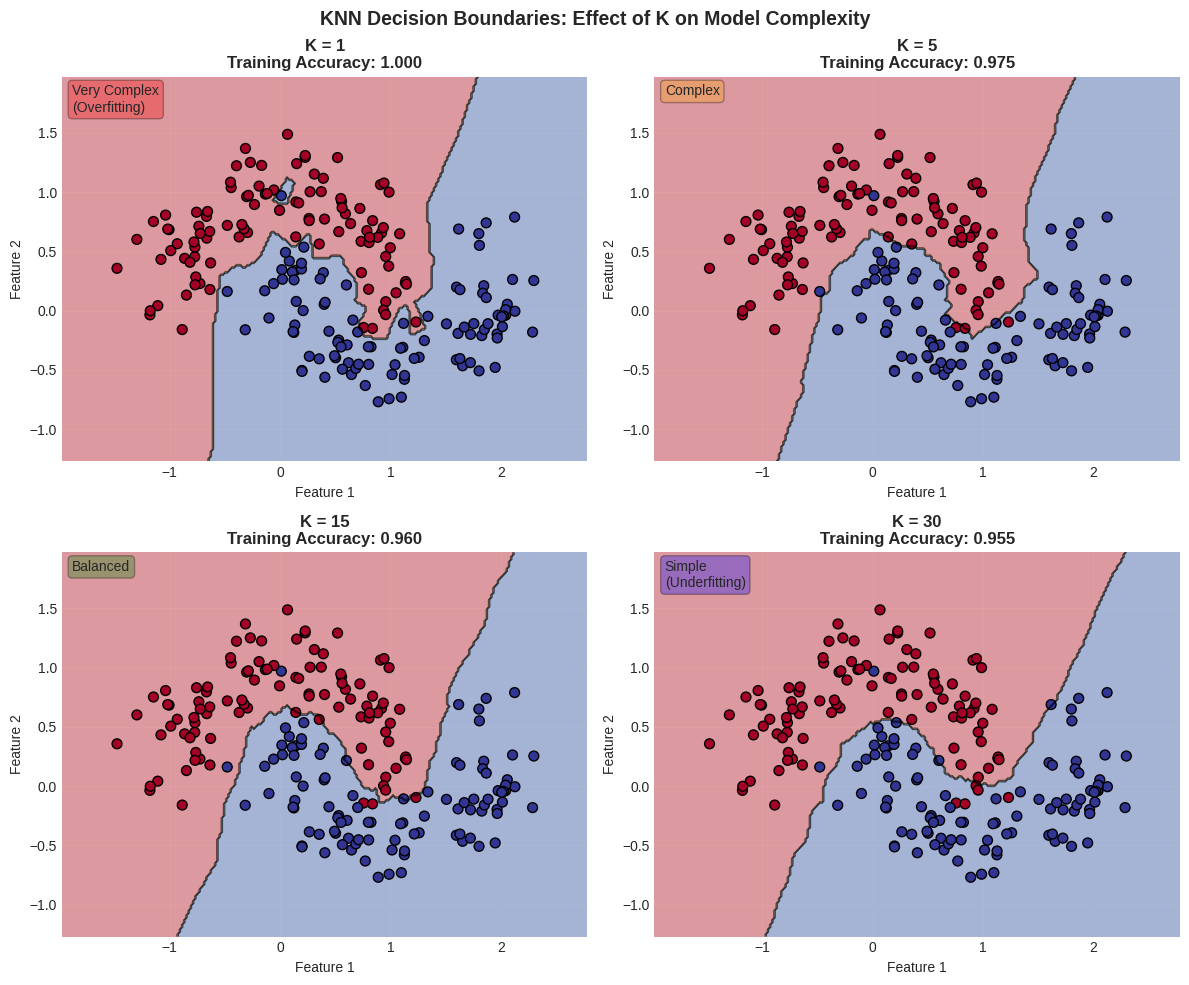

In [19]:
def plot_knn_decision_boundary(k_values=[1, 5, 15, 30]):
    """Visualize how different K values affect decision boundaries"""
    
    # Generate a complex dataset
    X, y = make_moons(n_samples=200, noise=0.2, random_state=42)
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.ravel()
    
    for idx, k in enumerate(k_values):
        ax = axes[idx]
        
        # Train KNN
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X, y)
        
        # Create mesh
        h = 0.02
        x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
        y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                            np.arange(y_min, y_max, h))
        
        # Predict on mesh
        Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        
        # Plot decision boundary
        ax.contourf(xx, yy, Z, alpha=0.4, cmap='RdYlBu')
        ax.contour(xx, yy, Z, colors='black', linewidths=0.5, alpha=0.4)
        
        # Plot data points
        scatter = ax.scatter(X[:, 0], X[:, 1], c=y, cmap='RdYlBu', 
                           edgecolors='black', linewidth=1, s=50)
        
        # Calculate and display accuracy
        accuracy = knn.score(X, y)
        
        ax.set_title(f'K = {k}\nTraining Accuracy: {accuracy:.3f}', 
                    fontsize=12, fontweight='bold')
        ax.set_xlabel('Feature 1')
        ax.set_ylabel('Feature 2')
        ax.grid(True, alpha=0.3)
        
        # Add text annotation about complexity
        if k == 1:
            complexity = "Very Complex\n(Overfitting)"
            color = 'red'
        elif k <= 5:
            complexity = "Complex"
            color = 'orange'
        elif k <= 15:
            complexity = "Balanced"
            color = 'green'
        else:
            complexity = "Simple\n(Underfitting)"
            color = 'blue'
        
        ax.text(0.02, 0.98, complexity, transform=ax.transAxes, 
               fontsize=10, verticalalignment='top',
               bbox=dict(boxstyle='round', facecolor=color, alpha=0.3))
    
    plt.suptitle('KNN Decision Boundaries: Effect of K on Model Complexity', 
                fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

plot_knn_decision_boundary()

### The Bias-Variance Tradeoff in KNN

The choice of K is crucial in KNN and perfectly illustrates the bias-variance tradeoff:

- **Small K (e.g., K=1)**:
  - **Low Bias**: Can capture very complex patterns
  - **High Variance**: Very sensitive to noise and outliers
  - **Risk**: Overfitting to training data
  
- **Large K (e.g., K=n)**:
  - **High Bias**: Makes simplistic predictions
  - **Low Variance**: Stable predictions
  - **Risk**: Underfitting, missing important patterns

Let's empirically demonstrate this tradeoff:

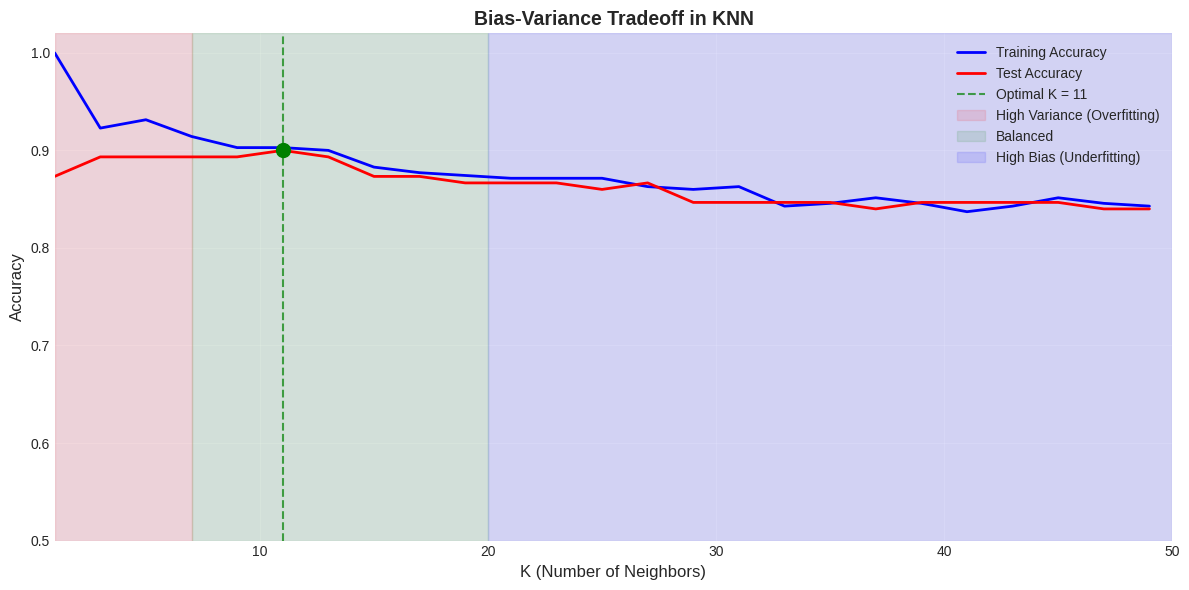


Analysis Results:
Optimal K: 11
Best Test Accuracy: 0.900
Training Accuracy at Optimal K: 0.903

Overfitting at K=1:
  Training Accuracy: 1.000
  Test Accuracy: 0.873
  Gap: 0.127


In [20]:
def analyze_bias_variance_tradeoff():
    """Analyze how K affects bias and variance"""
    
    # Generate dataset
    X, y = make_classification(n_samples=500, n_features=2, n_informative=2,
                              n_redundant=0, n_clusters_per_class=2, 
                              flip_y=0.1, random_state=42)
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Test different K values
    k_values = range(1, 51, 2)
    train_scores = []
    test_scores = []
    
    for k in k_values:
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train_scaled, y_train)
        
        train_score = knn.score(X_train_scaled, y_train)
        test_score = knn.score(X_test_scaled, y_test)
        
        train_scores.append(train_score)
        test_scores.append(test_score)
    
    # Find optimal K
    optimal_k_idx = np.argmax(test_scores)
    optimal_k = list(k_values)[optimal_k_idx]
    
    # Plotting
    plt.figure(figsize=(12, 6))
    
    plt.plot(k_values, train_scores, 'b-', label='Training Accuracy', linewidth=2)
    plt.plot(k_values, test_scores, 'r-', label='Test Accuracy', linewidth=2)
    
    # Mark optimal K
    plt.axvline(x=optimal_k, color='green', linestyle='--', alpha=0.7, 
               label=f'Optimal K = {optimal_k}')
    plt.scatter([optimal_k], [test_scores[optimal_k_idx]], 
               color='green', s=100, zorder=5)
    
    # Add shaded regions
    plt.axvspan(1, 7, alpha=0.1, color='red', label='High Variance (Overfitting)')
    plt.axvspan(7, 20, alpha=0.1, color='green', label='Balanced')
    plt.axvspan(20, 50, alpha=0.1, color='blue', label='High Bias (Underfitting)')
    
    plt.xlabel('K (Number of Neighbors)', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.title('Bias-Variance Tradeoff in KNN', fontsize=14, fontweight='bold')
    plt.legend(loc='best')
    plt.grid(True, alpha=0.3)
    plt.xlim(1, 50)
    plt.ylim(0.5, 1.02)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nAnalysis Results:")
    print(f"="*40)
    print(f"Optimal K: {optimal_k}")
    print(f"Best Test Accuracy: {test_scores[optimal_k_idx]:.3f}")
    print(f"Training Accuracy at Optimal K: {train_scores[optimal_k_idx]:.3f}")
    print(f"\nOverfitting at K=1:")
    print(f"  Training Accuracy: {train_scores[0]:.3f}")
    print(f"  Test Accuracy: {test_scores[0]:.3f}")
    print(f"  Gap: {train_scores[0] - test_scores[0]:.3f}")

analyze_bias_variance_tradeoff()

## Part 3: The Critical Importance of Feature Scaling

### Why Scaling Matters for KNN

Feature scaling is absolutely critical for KNN, more so than for many other algorithms. This is because KNN relies entirely on distance calculations, and features with larger scales will dominate the distance metric.

Consider a dataset with two features:
- Age (ranging from 0 to 100)
- Income (ranging from 20,000 to 200,000)

Without scaling, the income feature will completely dominate the distance calculations, making age almost irrelevant. This is rarely what we want!

### Types of Scaling

Let's explore different scaling techniques and their effects:

Impact of Feature Scaling on KNN Performance

Dataset Statistics:
Age range: 18.3 - 79.6
Income range: $20834 - $199949
Purchases range: 1.1 - 12.0

Class distribution: [374 126] (0: Regular, 1: High-value)


No Scaling          
  Accuracy:  0.727
  Precision: 0.316
  Recall:    0.176
  F1-Score:  0.226

StandardScaler      
  Accuracy:  0.847
  Precision: 0.690
  Recall:    0.588
  F1-Score:  0.635

MinMaxScaler        
  Accuracy:  0.847
  Precision: 0.690
  Recall:    0.588
  F1-Score:  0.635

RobustScaler        
  Accuracy:  0.847
  Precision: 0.690
  Recall:    0.588
  F1-Score:  0.635


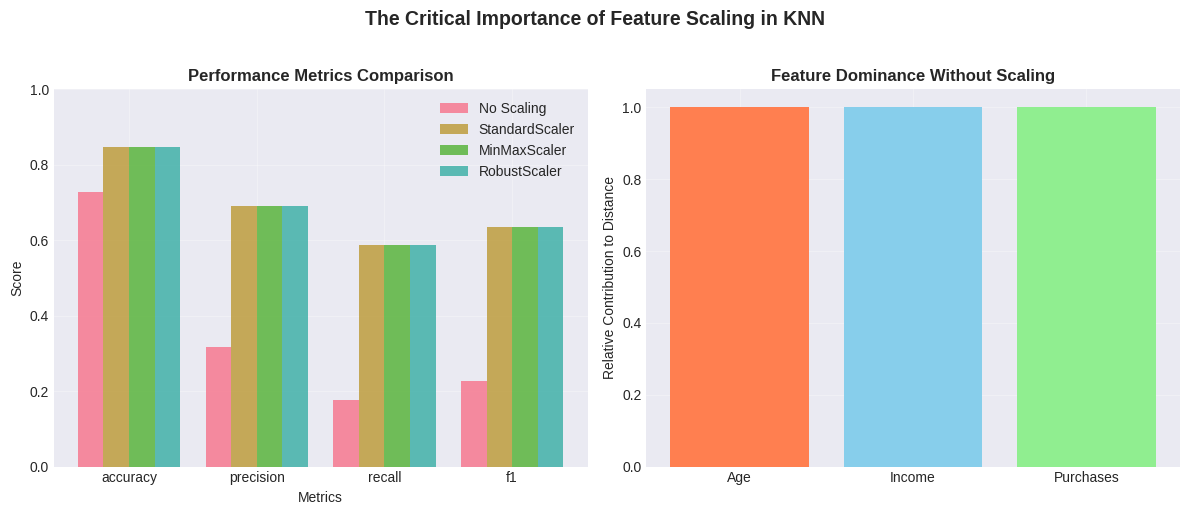

In [21]:
def demonstrate_scaling_importance():
    """Show the dramatic impact of feature scaling on KNN"""
    
    # Create a dataset with vastly different scales
    np.random.seed(42)
    n_samples = 500
    
    # Feature 1: Age (0-80 years)
    age = np.random.uniform(18, 80, n_samples)
    
    # Feature 2: Income ($20k - $200k)
    income = np.random.uniform(20000, 200000, n_samples)
    
    # Feature 3: Purchase frequency (1-12 times per year)
    purchases = np.random.uniform(1, 12, n_samples)
    
    # Create target based on a combination of features
    # High-value customers: older, higher income, frequent purchases
    y = ((age > 40) & (income > 100000) & (purchases > 6)).astype(int)
    
    # Add some noise
    noise_idx = np.random.choice(n_samples, size=int(0.1 * n_samples), replace=False)
    y[noise_idx] = 1 - y[noise_idx]
    
    # Combine features
    X = np.column_stack([age, income, purchases])
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    # Test different scaling methods
    scalers = {
        'No Scaling': None,
        'StandardScaler': StandardScaler(),
        'MinMaxScaler': MinMaxScaler(),
        'RobustScaler': RobustScaler()
    }
    
    results = {}
    
    print("Impact of Feature Scaling on KNN Performance")
    print("=" * 60)
    print(f"\nDataset Statistics:")
    print(f"Age range: {age.min():.1f} - {age.max():.1f}")
    print(f"Income range: ${income.min():.0f} - ${income.max():.0f}")
    print(f"Purchases range: {purchases.min():.1f} - {purchases.max():.1f}")
    print(f"\nClass distribution: {np.bincount(y)} (0: Regular, 1: High-value)")
    print("\n" + "="*60)
    
    for name, scaler in scalers.items():
        if scaler is None:
            X_train_scaled = X_train
            X_test_scaled = X_test
        else:
            X_train_scaled = scaler.fit_transform(X_train)
            X_test_scaled = scaler.transform(X_test)
        
        # Train KNN
        knn = KNeighborsClassifier(n_neighbors=5)
        knn.fit(X_train_scaled, y_train)
        
        # Evaluate
        y_pred = knn.predict(X_test_scaled)
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        
        results[name] = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1
        }
        
        print(f"\n{name:20}")
        print(f"  Accuracy:  {accuracy:.3f}")
        print(f"  Precision: {precision:.3f}")
        print(f"  Recall:    {recall:.3f}")
        print(f"  F1-Score:  {f1:.3f}")
    
    # Visualize results
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # Metrics comparison
    metrics = ['accuracy', 'precision', 'recall', 'f1']
    x = np.arange(len(metrics))
    width = 0.2
    
    for i, (name, scores) in enumerate(results.items()):
        values = [scores[m] for m in metrics]
        axes[0].bar(x + i*width, values, width, label=name, alpha=0.8)
    
    axes[0].set_xlabel('Metrics')
    axes[0].set_ylabel('Score')
    axes[0].set_title('Performance Metrics Comparison', fontweight='bold')
    axes[0].set_xticks(x + width * 1.5)
    axes[0].set_xticklabels(metrics)
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    axes[0].set_ylim([0, 1])
    
    # Feature importance without scaling
    knn_unscaled = KNeighborsClassifier(n_neighbors=5)
    knn_unscaled.fit(X_train, y_train)
    
    # Get a sample point and its neighbors
    sample_idx = 0
    sample_point = X_test[sample_idx:sample_idx+1]
    distances, indices = knn_unscaled.kneighbors(sample_point)
    
    # Calculate feature-wise distances
    feature_distances = np.abs(X_train[indices[0]] - sample_point)
    mean_feature_distances = feature_distances.mean(axis=0)[0]
    
    # Normalize to show relative importance
    feature_importance = mean_feature_distances / mean_feature_distances.sum()
    
    axes[1].bar(['Age', 'Income', 'Purchases'], feature_importance, color=['coral', 'skyblue', 'lightgreen'])
    axes[1].set_ylabel('Relative Contribution to Distance')
    axes[1].set_title('Feature Dominance Without Scaling', fontweight='bold')
    axes[1].grid(True, alpha=0.3)
    
    plt.suptitle('The Critical Importance of Feature Scaling in KNN', 
                fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()

demonstrate_scaling_importance()

### Deep Dive: Different Scaling Techniques

Let's explore each scaling technique in detail and understand when to use each one:

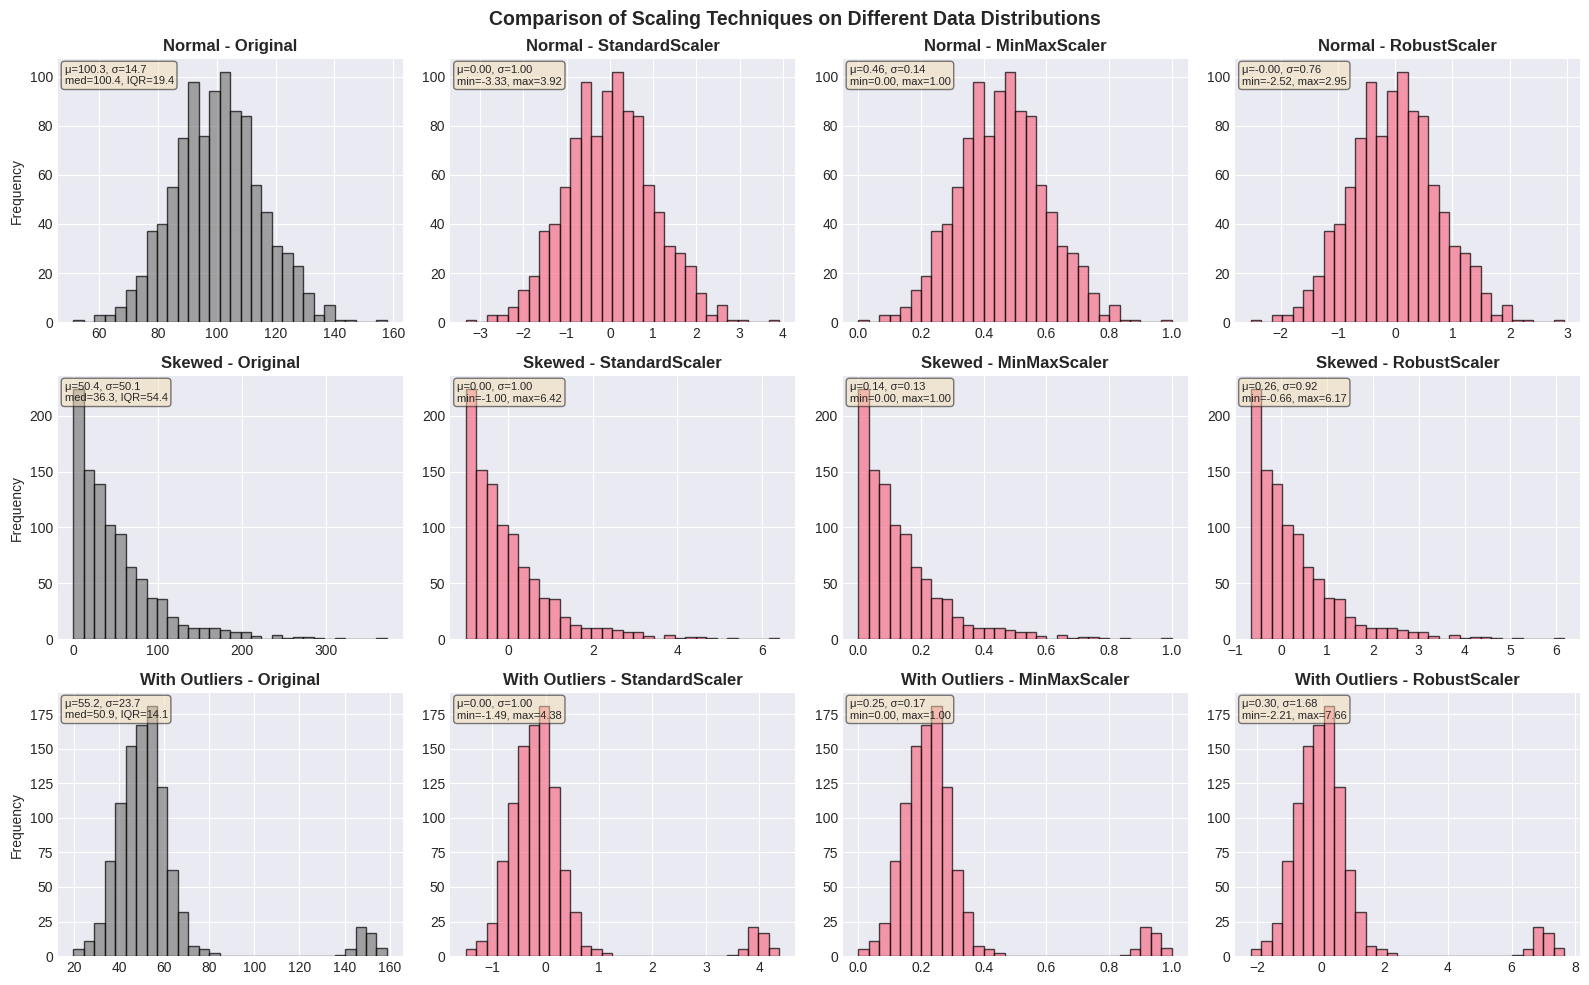


Scaling Techniques Comparison

1. StandardScaler (Z-score normalization)
   - Centers data around 0 with standard deviation of 1
   - Best for: Normally distributed features
   - Preserves shape of distribution
   - Sensitive to outliers

2. MinMaxScaler
   - Scales features to a fixed range [0, 1]
   - Best for: Features with known bounds
   - Preserves zero values
   - Very sensitive to outliers

3. RobustScaler
   - Uses median and IQR instead of mean and std
   - Best for: Data with outliers
   - Robust to outliers
   - May not bound features to specific range


In [22]:
def visualize_scaling_techniques():
    """Visualize the effect of different scaling techniques on data distribution"""
    
    # Generate data with different distributions
    np.random.seed(42)
    n_samples = 1000
    
    # Normal distribution
    normal_data = np.random.normal(100, 15, n_samples)
    
    # Skewed distribution
    skewed_data = np.random.exponential(50, n_samples)
    
    # Data with outliers
    outlier_data = np.concatenate([
        np.random.normal(50, 10, int(0.95 * n_samples)),
        np.random.normal(150, 5, int(0.05 * n_samples))
    ])
    np.random.shuffle(outlier_data)
    
    datasets = {
        'Normal': normal_data,
        'Skewed': skewed_data,
        'With Outliers': outlier_data
    }
    
    scalers = {
        'StandardScaler': StandardScaler(),
        'MinMaxScaler': MinMaxScaler(),
        'RobustScaler': RobustScaler()
    }
    
    fig, axes = plt.subplots(3, 4, figsize=(16, 10))
    
    for row, (data_name, data) in enumerate(datasets.items()):
        # Original data
        axes[row, 0].hist(data, bins=30, alpha=0.7, color='gray', edgecolor='black')
        axes[row, 0].set_title(f'{data_name} - Original', fontweight='bold')
        axes[row, 0].set_ylabel('Frequency')
        
        stats = f"μ={np.mean(data):.1f}, σ={np.std(data):.1f}\n"
        stats += f"med={np.median(data):.1f}, IQR={np.percentile(data, 75) - np.percentile(data, 25):.1f}"
        axes[row, 0].text(0.02, 0.98, stats, transform=axes[row, 0].transAxes,
                         verticalalignment='top', fontsize=8,
                         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
        
        # Apply different scalers
        for col, (scaler_name, scaler) in enumerate(scalers.items(), 1):
            scaled_data = scaler.fit_transform(data.reshape(-1, 1)).flatten()
            
            axes[row, col].hist(scaled_data, bins=30, alpha=0.7, edgecolor='black')
            axes[row, col].set_title(f'{data_name} - {scaler_name}', fontweight='bold')
            
            stats = f"μ={np.mean(scaled_data):.2f}, σ={np.std(scaled_data):.2f}\n"
            stats += f"min={np.min(scaled_data):.2f}, max={np.max(scaled_data):.2f}"
            axes[row, col].text(0.02, 0.98, stats, transform=axes[row, col].transAxes,
                               verticalalignment='top', fontsize=8,
                               bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.suptitle('Comparison of Scaling Techniques on Different Data Distributions', 
                fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Print detailed comparison
    print("\nScaling Techniques Comparison")
    print("=" * 80)
    print("\n1. StandardScaler (Z-score normalization)")
    print("   - Centers data around 0 with standard deviation of 1")
    print("   - Best for: Normally distributed features")
    print("   - Preserves shape of distribution")
    print("   - Sensitive to outliers")
    
    print("\n2. MinMaxScaler")
    print("   - Scales features to a fixed range [0, 1]")
    print("   - Best for: Features with known bounds")
    print("   - Preserves zero values")
    print("   - Very sensitive to outliers")
    
    print("\n3. RobustScaler")
    print("   - Uses median and IQR instead of mean and std")
    print("   - Best for: Data with outliers")
    print("   - Robust to outliers")
    print("   - May not bound features to specific range")

visualize_scaling_techniques()

## Part 4: Advanced Classification Evaluation

### Beyond Accuracy: Understanding Classification Metrics

When evaluating KNN classifiers, accuracy alone is often insufficient, especially with imbalanced datasets. Let's explore more sophisticated evaluation techniques.

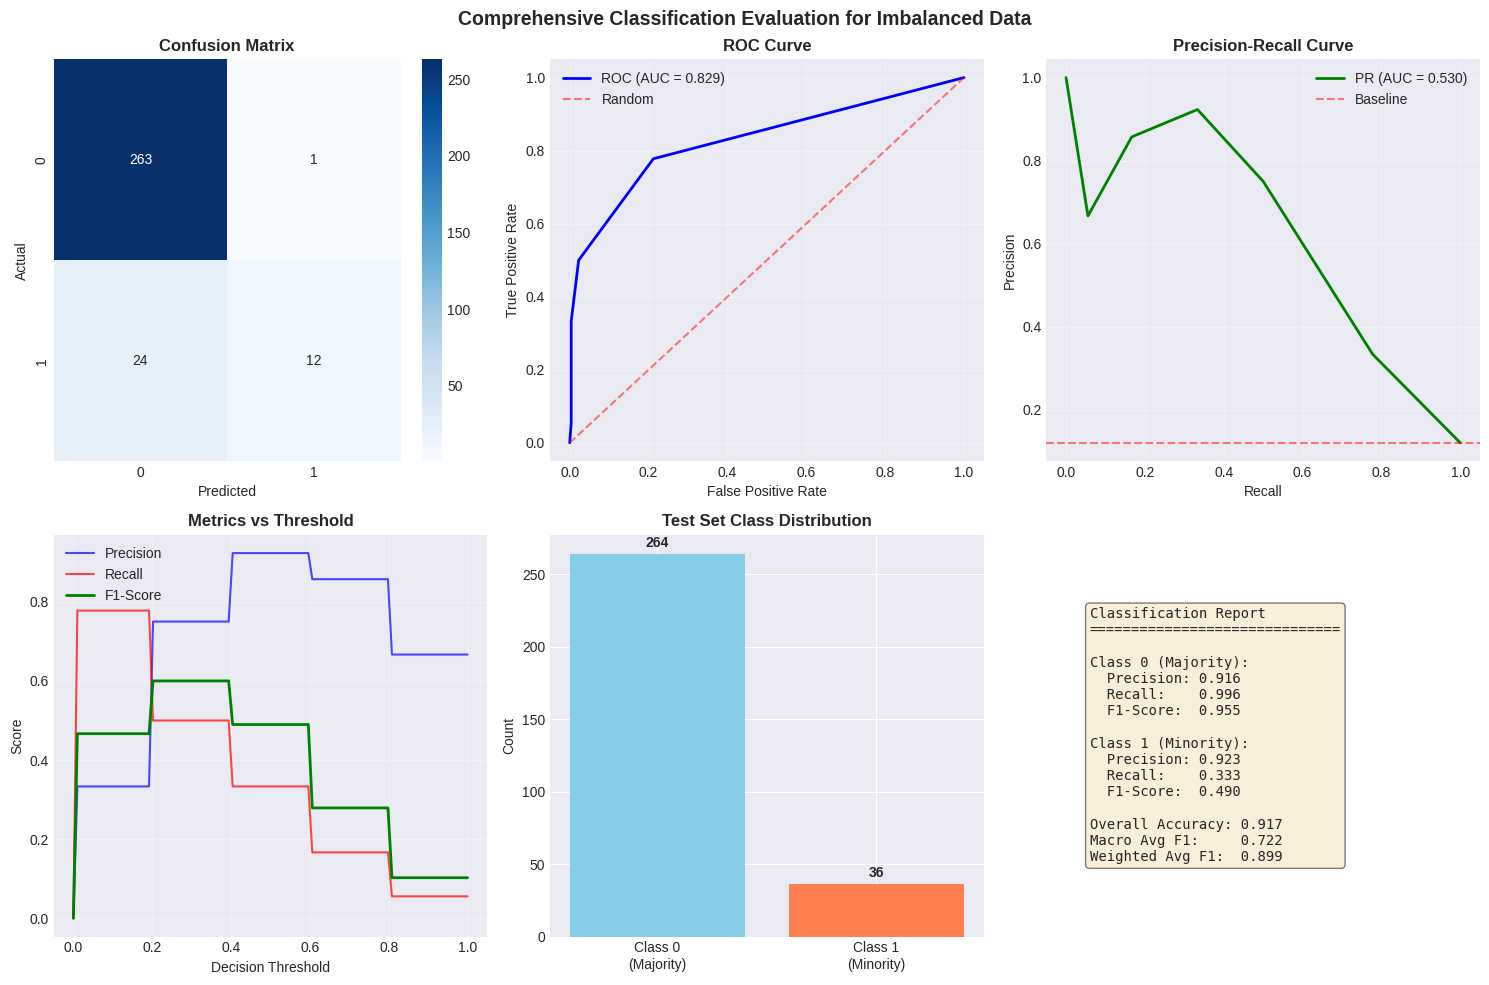


Key Insights from Evaluation:
1. Class Imbalance: 264/36 = 7.3:1 ratio
2. ROC AUC (0.829) vs PR AUC (0.530):
   - PR curve is more informative for imbalanced data
   - Baseline for PR curve is 0.120 (minority class proportion)
3. Accuracy (0.917) can be misleading:
   - A dummy classifier predicting all majority class would get 0.880 accuracy
4. F1-Score balances precision and recall, making it better for imbalanced data


In [23]:
def comprehensive_classification_evaluation():
    """Demonstrate comprehensive evaluation metrics for classification"""
    
    # Create an imbalanced dataset
    from sklearn.datasets import make_classification
    
    X, y = make_classification(n_samples=1000, n_features=20, n_informative=15,
                              n_redundant=5, n_classes=2, weights=[0.9, 0.1],
                              flip_y=0.05, random_state=42)
    
    # Split and scale
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, 
                                                       stratify=y, random_state=42)
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Train KNN
    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(X_train_scaled, y_train)
    
    # Get predictions and probabilities
    y_pred = knn.predict(X_test_scaled)
    y_proba = knn.predict_proba(X_test_scaled)[:, 1]
    
    # Create comprehensive visualization
    fig = plt.figure(figsize=(15, 10))
    
    # 1. Confusion Matrix
    ax1 = plt.subplot(2, 3, 1)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1)
    ax1.set_title('Confusion Matrix', fontweight='bold')
    ax1.set_xlabel('Predicted')
    ax1.set_ylabel('Actual')
    
    # 2. ROC Curve
    ax2 = plt.subplot(2, 3, 2)
    fpr, tpr, roc_thresholds = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    ax2.plot(fpr, tpr, 'b-', label=f'ROC (AUC = {roc_auc:.3f})', linewidth=2)
    ax2.plot([0, 1], [0, 1], 'r--', label='Random', alpha=0.5)
    ax2.set_xlabel('False Positive Rate')
    ax2.set_ylabel('True Positive Rate')
    ax2.set_title('ROC Curve', fontweight='bold')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # 3. Precision-Recall Curve
    ax3 = plt.subplot(2, 3, 3)
    precision, recall, pr_thresholds = precision_recall_curve(y_test, y_proba)
    pr_auc = average_precision_score(y_test, y_proba)
    ax3.plot(recall, precision, 'g-', label=f'PR (AUC = {pr_auc:.3f})', linewidth=2)
    ax3.axhline(y=y_test.mean(), color='r', linestyle='--', label='Baseline', alpha=0.5)
    ax3.set_xlabel('Recall')
    ax3.set_ylabel('Precision')
    ax3.set_title('Precision-Recall Curve', fontweight='bold')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # 4. Threshold Analysis
    ax4 = plt.subplot(2, 3, 4)
    thresholds = np.linspace(0, 1, 100)
    precisions = []
    recalls = []
    f1_scores = []
    
    for threshold in thresholds:
        y_pred_thresh = (y_proba >= threshold).astype(int)
        if len(np.unique(y_pred_thresh)) > 1:  # Avoid division by zero
            precisions.append(precision_score(y_test, y_pred_thresh, zero_division=0))
            recalls.append(recall_score(y_test, y_pred_thresh, zero_division=0))
            f1_scores.append(f1_score(y_test, y_pred_thresh, zero_division=0))
        else:
            precisions.append(0)
            recalls.append(0)
            f1_scores.append(0)
    
    ax4.plot(thresholds, precisions, 'b-', label='Precision', alpha=0.7)
    ax4.plot(thresholds, recalls, 'r-', label='Recall', alpha=0.7)
    ax4.plot(thresholds, f1_scores, 'g-', label='F1-Score', linewidth=2)
    ax4.set_xlabel('Decision Threshold')
    ax4.set_ylabel('Score')
    ax4.set_title('Metrics vs Threshold', fontweight='bold')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    # 5. Class Distribution
    ax5 = plt.subplot(2, 3, 5)
    class_counts = np.bincount(y_test)
    ax5.bar(['Class 0\n(Majority)', 'Class 1\n(Minority)'], class_counts, 
           color=['skyblue', 'coral'])
    ax5.set_ylabel('Count')
    ax5.set_title('Test Set Class Distribution', fontweight='bold')
    for i, count in enumerate(class_counts):
        ax5.text(i, count + 5, str(count), ha='center', fontweight='bold')
    
    # 6. Classification Report
    ax6 = plt.subplot(2, 3, 6)
    ax6.axis('off')
    
    report = classification_report(y_test, y_pred, output_dict=True)
    report_text = "Classification Report\n" + "="*30 + "\n\n"
    report_text += f"Class 0 (Majority):\n"
    report_text += f"  Precision: {report['0']['precision']:.3f}\n"
    report_text += f"  Recall:    {report['0']['recall']:.3f}\n"
    report_text += f"  F1-Score:  {report['0']['f1-score']:.3f}\n\n"
    report_text += f"Class 1 (Minority):\n"
    report_text += f"  Precision: {report['1']['precision']:.3f}\n"
    report_text += f"  Recall:    {report['1']['recall']:.3f}\n"
    report_text += f"  F1-Score:  {report['1']['f1-score']:.3f}\n\n"
    report_text += f"Overall Accuracy: {report['accuracy']:.3f}\n"
    report_text += f"Macro Avg F1:     {report['macro avg']['f1-score']:.3f}\n"
    report_text += f"Weighted Avg F1:  {report['weighted avg']['f1-score']:.3f}"
    
    ax6.text(0.1, 0.5, report_text, transform=ax6.transAxes,
            fontsize=10, verticalalignment='center',
            fontfamily='monospace',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.suptitle('Comprehensive Classification Evaluation for Imbalanced Data', 
                fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Print insights
    print("\nKey Insights from Evaluation:")
    print("=" * 60)
    print(f"1. Class Imbalance: {class_counts[0]}/{class_counts[1]} = {class_counts[0]/class_counts[1]:.1f}:1 ratio")
    print(f"2. ROC AUC ({roc_auc:.3f}) vs PR AUC ({pr_auc:.3f}):")
    print(f"   - PR curve is more informative for imbalanced data")
    print(f"   - Baseline for PR curve is {y_test.mean():.3f} (minority class proportion)")
    print(f"3. Accuracy ({report['accuracy']:.3f}) can be misleading:")
    print(f"   - A dummy classifier predicting all majority class would get {1-y_test.mean():.3f} accuracy")
    print(f"4. F1-Score balances precision and recall, making it better for imbalanced data")

comprehensive_classification_evaluation()

## Part 5: Practice Exercises

Now it's time to apply what you've learned! Below are practice exercises with varying difficulty levels.

### Exercise 1: Basic KNN Implementation (Beginner)

**Task**: Implement a function that finds the k nearest neighbors for a given point without using sklearn.

In [24]:
def find_k_nearest_neighbors(X_train, X_test_point, k=3):
    """
    Find the k nearest neighbors for a test point.
    
    Parameters:
    -----------
    X_train : numpy array of shape (n_samples, n_features)
        Training data
    X_test_point : numpy array of shape (n_features,)
        Single test point
    k : int
        Number of neighbors to find
    
    Returns:
    --------
    indices : numpy array
        Indices of k nearest neighbors
    distances : numpy array
        Distances to k nearest neighbors
    """
    # YOUR CODE HERE
    # Hint: Calculate distances, sort them, return k smallest
    pass

# Test your implementation
X_train = np.array([[1, 2], [3, 4], [5, 6], [7, 8], [9, 10]])
X_test_point = np.array([4, 5])
k = 3

# Your function
# indices, distances = find_k_nearest_neighbors(X_train, X_test_point, k)
# print(f"Nearest neighbor indices: {indices}")
# print(f"Distances: {distances}")

### Exercise 1: Solution

In [ ]:
def find_k_nearest_neighbors_solution(X_train, X_test_point, k=3):
    """
    Solution: Find the k nearest neighbors for a test point.
    """
    # Calculate Euclidean distances to all training points
    distances = np.sqrt(np.sum((X_train - X_test_point) ** 2, axis=1))
    
    # Get indices that would sort the distances
    sorted_indices = np.argsort(distances)
    
    # Return k nearest indices and their distances
    k_nearest_indices = sorted_indices[:k]
    k_nearest_distances = distances[k_nearest_indices]
    
    return k_nearest_indices, k_nearest_distances

# Test the solution
X_train = np.array([[1, 2], [3, 4], [5, 6], [7, 8], [9, 10]])
X_test_point = np.array([4, 5])
k = 3

indices, distances = find_k_nearest_neighbors_solution(X_train, X_test_point, k)
print(f"Nearest neighbor indices: {indices}")
print(f"Distances: {np.array2string(distances, precision=2)}")
print(f"Nearest points: \n{X_train[indices]}")

Nearest neighbor indices: [1 2 0]


ValueError: Unknown format code 'f' for object of type 'str'

### Exercise 2: Optimal K Selection (Intermediate)

**Task**: Write a function that finds the optimal K value using cross-validation for a given dataset.

In [ ]:
def find_optimal_k(X, y, k_range=range(1, 31), cv_folds=5):
    """
    Find the optimal K value using cross-validation.
    
    Parameters:
    -----------
    X : numpy array
        Features
    y : numpy array
        Labels
    k_range : range object
        Range of K values to test
    cv_folds : int
        Number of cross-validation folds
    
    Returns:
    --------
    optimal_k : int
        The K value with best cross-validation score
    scores : dict
        Dictionary mapping K values to their CV scores
    """
    # YOUR CODE HERE
    # Hint: Use cross_val_score from sklearn for each K value
    pass

# Create a dataset to test
X, y = make_classification(n_samples=200, n_features=5, n_informative=3, random_state=42)

# Your function
# optimal_k, scores = find_optimal_k(X, y)
# print(f"Optimal K: {optimal_k}")

### Exercise 2: Solution

In [ ]:
def find_optimal_k_solution(X, y, k_range=range(1, 31), cv_folds=5):
    """
    Solution: Find the optimal K value using cross-validation.
    """
    from sklearn.model_selection import cross_val_score
    from sklearn.preprocessing import StandardScaler
    from sklearn.pipeline import Pipeline
    
    scores = {}
    best_score = 0
    optimal_k = 1
    
    for k in k_range:
        # Create pipeline with scaling and KNN
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('knn', KNeighborsClassifier(n_neighbors=k))
        ])
        
        # Perform cross-validation
        cv_scores = cross_val_score(pipeline, X, y, cv=cv_folds, scoring='accuracy')
        mean_score = cv_scores.mean()
        
        scores[k] = mean_score
        
        # Update best K if current is better
        if mean_score > best_score:
            best_score = mean_score
            optimal_k = k
    
    # Visualize results
    plt.figure(figsize=(10, 5))
    plt.plot(list(scores.keys()), list(scores.values()), 'b-', linewidth=2)
    plt.axvline(x=optimal_k, color='red', linestyle='--', 
               label=f'Optimal K = {optimal_k}')
    plt.scatter([optimal_k], [scores[optimal_k]], color='red', s=100, zorder=5)
    plt.xlabel('K (Number of Neighbors)')
    plt.ylabel('Cross-Validation Accuracy')
    plt.title('Finding Optimal K through Cross-Validation')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    return optimal_k, scores

# Test the solution
X, y = make_classification(n_samples=200, n_features=5, n_informative=3, random_state=42)
optimal_k, scores = find_optimal_k_solution(X, y, k_range=range(1, 21))
print(f"Optimal K: {optimal_k}")
print(f"Best CV Score: {scores[optimal_k]:.3f}")

### Exercise 3: Building a Complete KNN Pipeline (Advanced)

**Task**: Build a complete KNN pipeline that includes:
1. Data preprocessing (handling missing values, scaling)
2. Feature selection
3. K optimization
4. Model evaluation with multiple metrics
5. Visualization of results

In [ ]:
def build_knn_pipeline(X, y, test_size=0.2):
    """
    Build a complete KNN pipeline with preprocessing and evaluation.
    
    Parameters:
    -----------
    X : pandas DataFrame or numpy array
        Features
    y : pandas Series or numpy array
        Target variable
    test_size : float
        Proportion of data to use for testing
    
    Returns:
    --------
    pipeline : sklearn Pipeline
        Trained pipeline
    results : dict
        Dictionary containing evaluation metrics and visualizations
    """
    # YOUR CODE HERE
    # This is a comprehensive exercise - take your time!
    pass

# Create a more complex dataset with missing values
from sklearn.datasets import load_breast_cancer
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = data.target

# Add some missing values
np.random.seed(42)
missing_mask = np.random.random(X.shape) < 0.05
X[missing_mask] = np.nan

print(f"Dataset shape: {X.shape}")
print(f"Missing values: {X.isnull().sum().sum()}")
print(f"Class distribution: {np.bincount(y)}")

# Your function
# pipeline, results = build_knn_pipeline(X, y)

### Exercise 3: Solution

In [ ]:
def build_knn_pipeline_solution(X, y, test_size=0.2):
    """
    Solution: Build a complete KNN pipeline with preprocessing and evaluation.
    """
    from sklearn.impute import SimpleImputer
    from sklearn.feature_selection import SelectKBest, f_classif
    from sklearn.pipeline import Pipeline
    from sklearn.model_selection import GridSearchCV
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=42, stratify=y
    )
    
    # Create pipeline
    pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler()),
        ('feature_selection', SelectKBest(f_classif)),
        ('knn', KNeighborsClassifier())
    ])
    
    # Define parameter grid for GridSearchCV
    param_grid = {
        'feature_selection__k': [10, 15, 20, 'all'],
        'knn__n_neighbors': [3, 5, 7, 9, 11],
        'knn__weights': ['uniform', 'distance'],
        'knn__metric': ['euclidean', 'manhattan']
    }
    
    # Perform grid search
    print("Performing Grid Search...")
    grid_search = GridSearchCV(
        pipeline, param_grid, cv=5, 
        scoring='f1_weighted', n_jobs=-1, verbose=1
    )
    grid_search.fit(X_train, y_train)
    
    # Best parameters
    print(f"\nBest parameters: {grid_search.best_params_}")
    print(f"Best CV score: {grid_search.best_score_:.3f}")
    
    # Evaluate on test set
    y_pred = grid_search.predict(X_test)
    y_proba = grid_search.predict_proba(X_test)[:, 1]
    
    # Calculate metrics
    results = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'roc_auc': auc(*roc_curve(y_test, y_proba)[:2]),
        'pr_auc': average_precision_score(y_test, y_proba)
    }
    
    # Visualization
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    
    # 1. Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0, 0])
    axes[0, 0].set_title('Confusion Matrix')
    axes[0, 0].set_xlabel('Predicted')
    axes[0, 0].set_ylabel('Actual')
    
    # 2. ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    axes[0, 1].plot(fpr, tpr, 'b-', linewidth=2)
    axes[0, 1].plot([0, 1], [0, 1], 'r--', alpha=0.5)
    axes[0, 1].set_xlabel('False Positive Rate')
    axes[0, 1].set_ylabel('True Positive Rate')
    axes[0, 1].set_title(f'ROC Curve (AUC = {results["roc_auc"]:.3f})')
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. PR Curve
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    axes[0, 2].plot(recall, precision, 'g-', linewidth=2)
    axes[0, 2].set_xlabel('Recall')
    axes[0, 2].set_ylabel('Precision')
    axes[0, 2].set_title(f'PR Curve (AUC = {results["pr_auc"]:.3f})')
    axes[0, 2].grid(True, alpha=0.3)
    
    # 4. Feature Importance (based on SelectKBest scores)
    selector = grid_search.best_estimator_.named_steps['feature_selection']
    if hasattr(selector, 'scores_'):
        feature_scores = selector.scores_
        top_features_idx = np.argsort(feature_scores)[-10:]
        top_features = X.columns[top_features_idx]
        top_scores = feature_scores[top_features_idx]
        
        axes[1, 0].barh(range(len(top_features)), top_scores)
        axes[1, 0].set_yticks(range(len(top_features)))
        axes[1, 0].set_yticklabels(top_features)
        axes[1, 0].set_xlabel('Feature Score')
        axes[1, 0].set_title('Top 10 Features')
    
    # 5. Metrics Comparison
    metrics_names = list(results.keys())
    metrics_values = list(results.values())
    axes[1, 1].bar(metrics_names, metrics_values, color='skyblue')
    axes[1, 1].set_ylabel('Score')
    axes[1, 1].set_title('Evaluation Metrics')
    axes[1, 1].set_ylim([0, 1])
    for i, v in enumerate(metrics_values):
        axes[1, 1].text(i, v + 0.01, f'{v:.3f}', ha='center')
    
    # 6. Parameter Impact
    param_impact = pd.DataFrame(grid_search.cv_results_)
    k_values = param_impact['param_knn__n_neighbors'].unique()
    mean_scores = [param_impact[param_impact['param_knn__n_neighbors'] == k]['mean_test_score'].mean() 
                  for k in k_values]
    axes[1, 2].plot(k_values, mean_scores, 'o-')
    axes[1, 2].set_xlabel('K (Number of Neighbors)')
    axes[1, 2].set_ylabel('Mean CV Score')
    axes[1, 2].set_title('K Value Impact on Performance')
    axes[1, 2].grid(True, alpha=0.3)
    
    plt.suptitle('Complete KNN Pipeline Evaluation', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Print summary
    print("\n" + "="*60)
    print("Pipeline Evaluation Summary")
    print("="*60)
    for metric, value in results.items():
        print(f"{metric.capitalize():15} {value:.3f}")
    
    return grid_search.best_estimator_, results

# Test the solution
pipeline, results = build_knn_pipeline_solution(X, y)

## Conclusion and Key Takeaways

### What We've Learned

In this comprehensive notebook, we've explored K-Nearest Neighbors from both theoretical and practical perspectives:

1. **Distance Metrics**: We learned how different distance metrics (Euclidean, Manhattan, Cosine) affect which points are considered "neighbors" and when to use each one.

2. **The KNN Algorithm**: We implemented KNN from scratch and saw how it makes predictions through voting (classification) or averaging (regression).

3. **Feature Scaling**: We demonstrated the critical importance of scaling features before using KNN, as features with larger scales dominate distance calculations.

4. **Choosing K**: We explored the bias-variance tradeoff and learned how to select the optimal K value through cross-validation.

5. **Evaluation Metrics**: We went beyond accuracy to understand ROC curves, PR curves, and why different metrics matter for different problems.

### Key Insights

- **KNN is simple but powerful**: Despite its simplicity, KNN can capture complex, non-linear patterns that linear models miss.

- **No free lunch**: KNN's flexibility comes at a computational cost - it needs to compute distances to all training points for each prediction.

- **Feature scaling is not optional**: Unlike tree-based models, KNN absolutely requires proper feature scaling to work correctly.

- **K is crucial**: Too small and you overfit to noise; too large and you oversimplify. Cross-validation is your friend.

- **Local vs Global**: KNN makes local decisions based on nearby points, unlike models like logistic regression that learn global patterns.

### When to Use KNN

**KNN excels when**:
- The decision boundary is irregular or non-linear
- Local patterns are more important than global patterns
- You have sufficient data density
- The dataset is not too high-dimensional

**Consider alternatives when**:
- You have very large datasets (computational cost)
- Features are high-dimensional (curse of dimensionality)
- You need a interpretable model
- You need fast predictions in production

### Next Steps

To deepen your understanding:

1. **Experiment with different datasets**: Try KNN on text data (using cosine distance), image data, and time series.

2. **Explore advanced techniques**:
   - Weighted KNN (giving closer neighbors more influence)
   - KD-Trees and Ball Trees for faster neighbor search
   - Approximate nearest neighbors for large-scale applications

3. **Compare with other algorithms**: See how KNN performs compared to decision trees, random forests, and neural networks on the same problems.

4. **Build a real application**: Implement a recommendation system or anomaly detector using KNN.

Remember: KNN might be "lazy" in that it doesn't build an explicit model, but mastering it requires active practice and experimentation!

Happy learning! 🎯